In [2]:
import pathlib
import matplotlib.pyplot as plt
import utils
import torch
from torch import nn
from dataloaders import load_cifar10
from trainer import compute_loss_and_accuracy
from trainer import Trainer
from task3 import create_plots
from task3 import print_accuracy

In [3]:
class ExampleModel(nn.Module):
    def __init__(self, image_channels, num_classes):
        """
        Is called when model is initialized.
        Args:
            image_channels. Number of color channels in image (3)
            num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(num_filters),
            
            nn.ReLU(),
            #nn.LeakyReLU(0.02),
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            #nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.MaxPool2d(2, 2),
            
            nn.ReLU(),
            #nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            #nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            #nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),
       
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.LeakyReLU(0.02),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        
        self.num_output_features = 128 * 2 * 2
        #self.num_output_features = 64 * 8 * 8
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            #nn.Linear(self.num_output_features, 64),
            #nn.BatchNorm1d(64),
            #nn.ReLU(),
            #nn.LeakyReLU(0.02),
            #nn.Linear(64 , num_classes)
            nn.Linear(self.num_output_features , num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(-1, self.num_output_features) #flatten
        
        out = self.classifier(x)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (
            batch_size,
            self.num_classes,
        ), f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [4]:
def create_plots_compare(trainer1: Trainer, trainer2: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    utils.plot_loss(
        trainer1.train_history["loss"], label="Training loss before", npoints_to_average=10
    )
    utils.plot_loss(
        trainer2.train_history["loss"], label="Training loss after", npoints_to_average=10
    )
    utils.plot_loss(trainer1.validation_history["loss"], label="Validation loss before")
    utils.plot_loss(trainer2.validation_history["loss"], label="Validation loss after")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    utils.plot_loss(trainer1.validation_history["accuracy"], label="Validation Accuracy before")
    utils.plot_loss(trainer2.validation_history["accuracy"], label="Validation Accuracy after")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
ExampleModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.05, inplace=False)
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

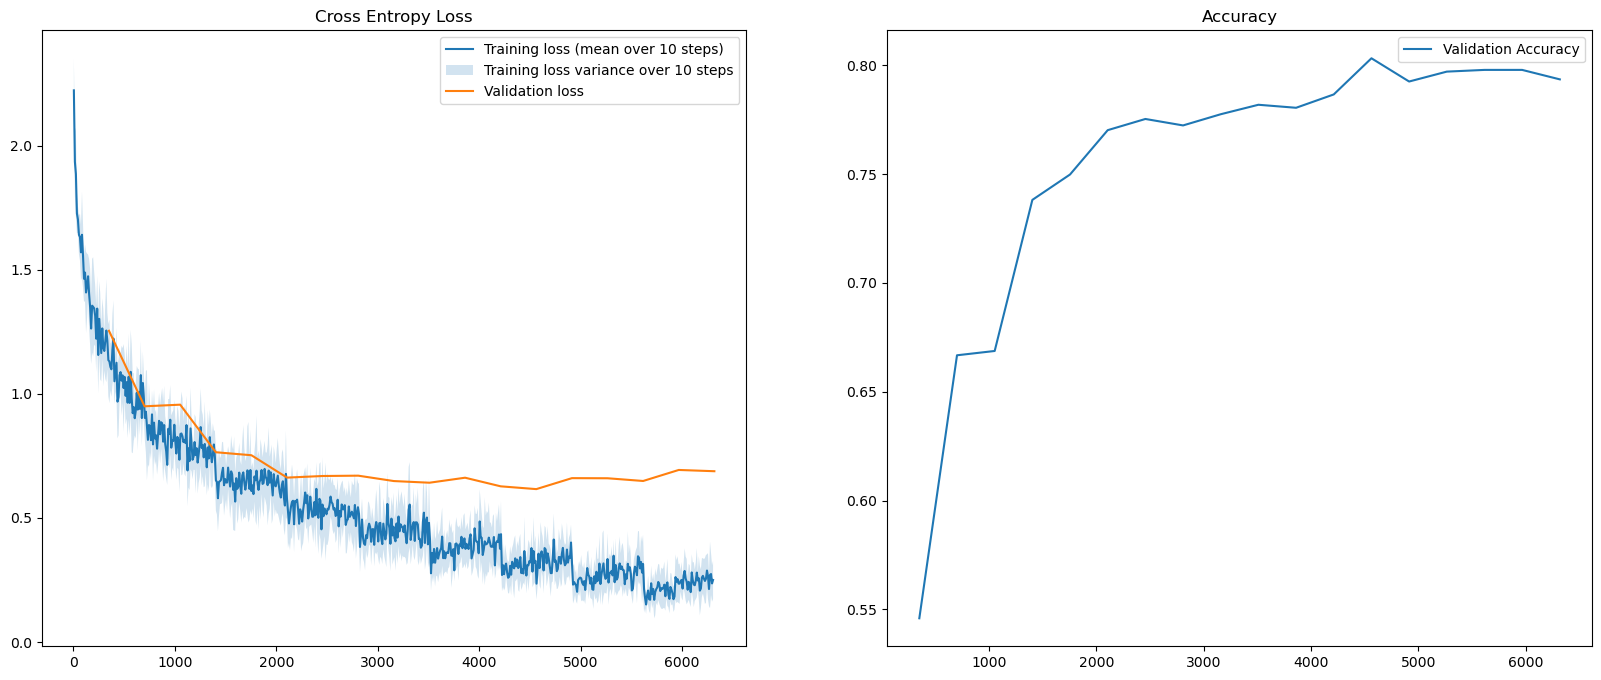

In [5]:
utils.set_seed(0)
print(f"Using device: {utils.get_device()}")
epochs = 10
batch_size = 64
learning_rate = 6e-1
early_stop_count = 6
dataloaders = load_cifar10(batch_size)
model = ExampleModel(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, model, dataloaders
)
trainer.optimizer = torch.optim.Adadelta(model.parameters(), learning_rate)

trainer.train()
print_accuracy(trainer)
create_plots(trainer, "task3")

In [6]:
last_trainer = trainer


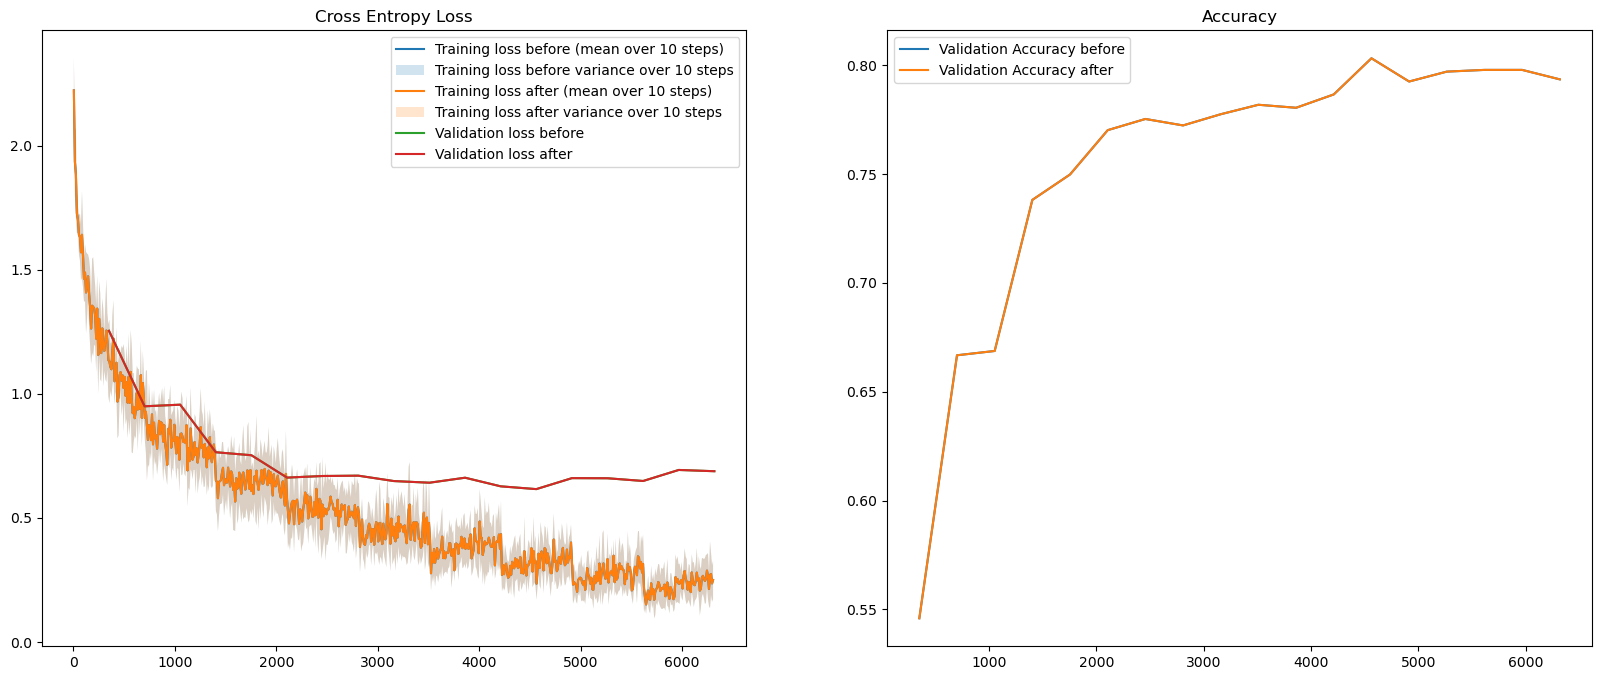

In [7]:

create_plots_compare(last_trainer, trainer, "comparison plot")